# humsn SKM MuSC Myocyte differentiation

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
import collections
import matplotlib.pyplot as plt
import time
import seaborn as sns
import scipy
from collections import Counter
import scipy.io
import jp_single

import scvi

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, color_map='YlOrRd')
sc.logging.print_version_and_date()

Running Scanpy 1.8.0, on 2023-02-17 15:20.


In [2]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells

In [3]:
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

***
Import data

In [4]:
rawadata = sc.read('./write/skm_cells_human_cellbender.raw_2021-03-24.h5ad')
adata_MuSC = sc.read('./write/humsn_SKM_MuSC_scVI_v1.3_adata.h5ad')
adata_Myocyte = sc.read('./write/humsn_SKM_Myocyte_scVI_v2.0_adata.h5ad')

In [5]:
adata_MuSC

AnnData object with n_obs × n_vars = 16955 × 10000
    obs: 'sample', 'barcode', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', 'SampleID', 'NoCells', 'NoGenes', 'QC', 'Sequencing saturation', '10X version ', 'Age_bin', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden', 'annotation', 'leiden_R'
    var: 'GeneID', 'feature_types', 'genome', 'GeneName', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '10X version _colors', 'DonorID_colors', '_scvi', 'annotation_colors', 'hvg', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
adata_Myocyte

AnnData object with n_obs × n_vars = 12415 × 10000
    obs: 'sample', 'barcode', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', 'SampleID', 'NoCells', 'NoGenes', 'QC', 'Sequencing saturation', '10X version ', 'Age_bin', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden', 'annotation'
    var: 'GeneID', 'feature_types', 'genome', 'GeneName', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'DonorID_colors', '_scvi', 'annotation_colors', 'hvg', 'leiden', 'leiden_R_colors', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [9]:
cell_list1 = adata_MuSC[adata_MuSC.obs['annotation']=='0-ICAM1+MuSCs'].obs.index
cell_list2 = adata_MuSC[adata_MuSC.obs['annotation']=='2-TNFRSF12A+MuSCs'].obs.index
cell_list3 = adata_MuSC[adata_MuSC.obs['annotation']=='3-MuSCs'].obs.index
cell_list4 = adata_MuSC[adata_MuSC.obs['annotation']=='5-MYOG+MuSCs'].obs.index
cell_list5 = adata_Myocyte[adata_Myocyte.obs['annotation']=='0-TNNT3+Myocytes'].obs.index
cell_list6 = adata_Myocyte[adata_Myocyte.obs['annotation']=='1-TNNT1+Myocytes'].obs.index
cell_list7 = adata_Myocyte[adata_Myocyte.obs['annotation']=='2-TNNT1+UCHL1+Myocytes'].obs.index
cell_list8 = adata_Myocyte[adata_Myocyte.obs['annotation']=='3-TNNT3+UCHL1+Myocytes'].obs.index
cell_list9 = adata_Myocyte[adata_Myocyte.obs['annotation']=='4-TNNT2+Myocytes'].obs.index
cell_list10 = adata_Myocyte[adata_Myocyte.obs['annotation']=='6-MYH8+Myocytes'].obs.index
cell_list11 = adata_Myocyte[adata_Myocyte.obs['annotation']=='7-HOOK2+Myocytes'].obs.index

cell_list = cell_list1.append(cell_list2).append(cell_list3).append(cell_list4).append(cell_list5).append(cell_list6).append(cell_list7).append(cell_list8).append(cell_list9).append(cell_list10).append(cell_list11)

In [10]:
adata = rawadata[cell_list]

In [11]:
adata.layers['counts'] = adata.X.copy()

In [12]:
adata

AnnData object with n_obs × n_vars = 26885 × 33694
    obs: 'sample', 'barcode', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', 'SampleID', 'NoCells', 'NoGenes', 'QC', 'Sequencing saturation', '10X version ', 'Age_bin', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo'
    var: 'GeneID', 'feature_types', 'genome', 'GeneName', 'n_counts', 'n_cells'
    layers: 'counts'

In [13]:
adata_MuSC.obs['cell_type']='MuSC'
adata_Myocyte.obs['cell_type']='Myocyte'

In [14]:
adata.obs['cell_type'] = adata_MuSC.obs['cell_type']
adata.obs.update(adata_Myocyte.obs)

In [15]:
adata.obs['annotation'] = adata_MuSC.obs['annotation']
adata.obs.update(adata_Myocyte.obs)

In [16]:
adata

AnnData object with n_obs × n_vars = 26885 × 33694
    obs: 'sample', 'barcode', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', 'SampleID', 'NoCells', 'NoGenes', 'QC', 'Sequencing saturation', '10X version ', 'Age_bin', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'cell_type', 'annotation'
    var: 'GeneID', 'feature_types', 'genome', 'GeneName', 'n_counts', 'n_cells'
    layers: 'counts'

In [17]:
collections.Counter(adata.obs['cell_type'])

Counter({'MuSC': 15606, 'Myocyte': 11279})

In [18]:
collections.Counter(adata.obs['annotation'])

Counter({'0-ICAM1+MuSCs': 1571,
         '2-TNFRSF12A+MuSCs': 1203,
         '3-MuSCs': 12767,
         '5-MYOG+MuSCs': 65,
         '0-TNNT3+Myocytes': 4745,
         '1-TNNT1+Myocytes': 5385,
         '2-TNNT1+UCHL1+Myocytes': 597,
         '3-TNNT3+UCHL1+Myocytes': 220,
         '4-TNNT2+Myocytes': 45,
         '6-MYH8+Myocytes': 145,
         '7-HOOK2+Myocytes': 142})

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # keep full dimension safe

normalizing counts per cell
    finished (0:00:00)


In [20]:
sc.pp.highly_variable_genes(
    adata,
    flavor="seurat_v3",
    n_top_genes=10000,
    layer="counts",
    batch_key='cell_type', subset = True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


In [21]:
adata

AnnData object with n_obs × n_vars = 26885 × 10000
    obs: 'sample', 'barcode', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', 'SampleID', 'NoCells', 'NoGenes', 'QC', 'Sequencing saturation', '10X version ', 'Age_bin', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'cell_type', 'annotation'
    var: 'GeneID', 'feature_types', 'genome', 'GeneName', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [22]:
scvi.data.setup_anndata(adata,layer="counts", batch_key="DonorID",
                       )

INFO     Using batches from adata.obs["DonorID"]                                             
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 26885 cells, 10000 vars, 10       
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [23]:
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30)

In [24]:
vae.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 298/298: 100%|██████████| 298/298 [15:40<00:00,  3.16s/it, loss=1.71e+03, v_num=1]


In [25]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [26]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:26)


In [7]:
adata

AnnData object with n_obs × n_vars = 26885 × 10000
    obs: 'sample', 'barcode', 'DonorID', 'Sex', 'Age', 'Species', 'Operator', 'Sample', 'SampleID', 'NoCells', 'NoGenes', 'QC', 'Sequencing saturation', '10X version ', 'Age_bin', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'cell_type', 'annotation', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden', 'annotation_1', 'annotation_2'
    var: 'GeneID', 'feature_types', 'genome', 'GeneName', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: '_scvi', 'annotation_1_colors', 'annotation_1_sizes', 'annotation_2_colors', 'annotation_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'umap'
    obsm: 'X_draw_graph_fa', 'X_scVI', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

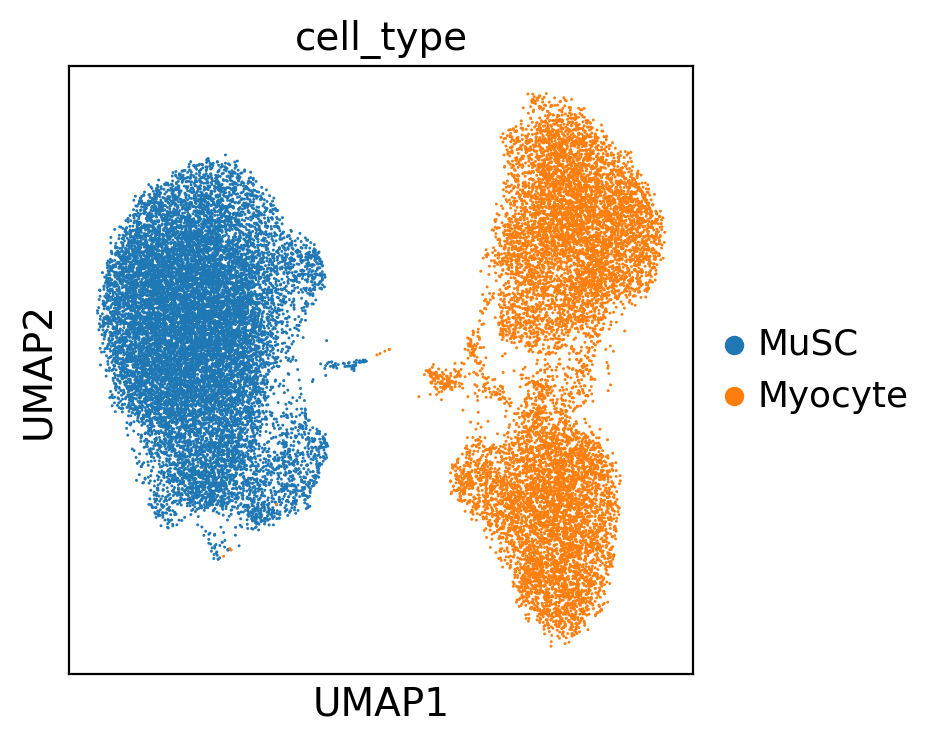

In [114]:
sc.pl.umap(adata, color=['cell_type',],save='humsn_SKM_MuSC_Myocyte_scVI_v1.3_muscmyocyte.pdf')

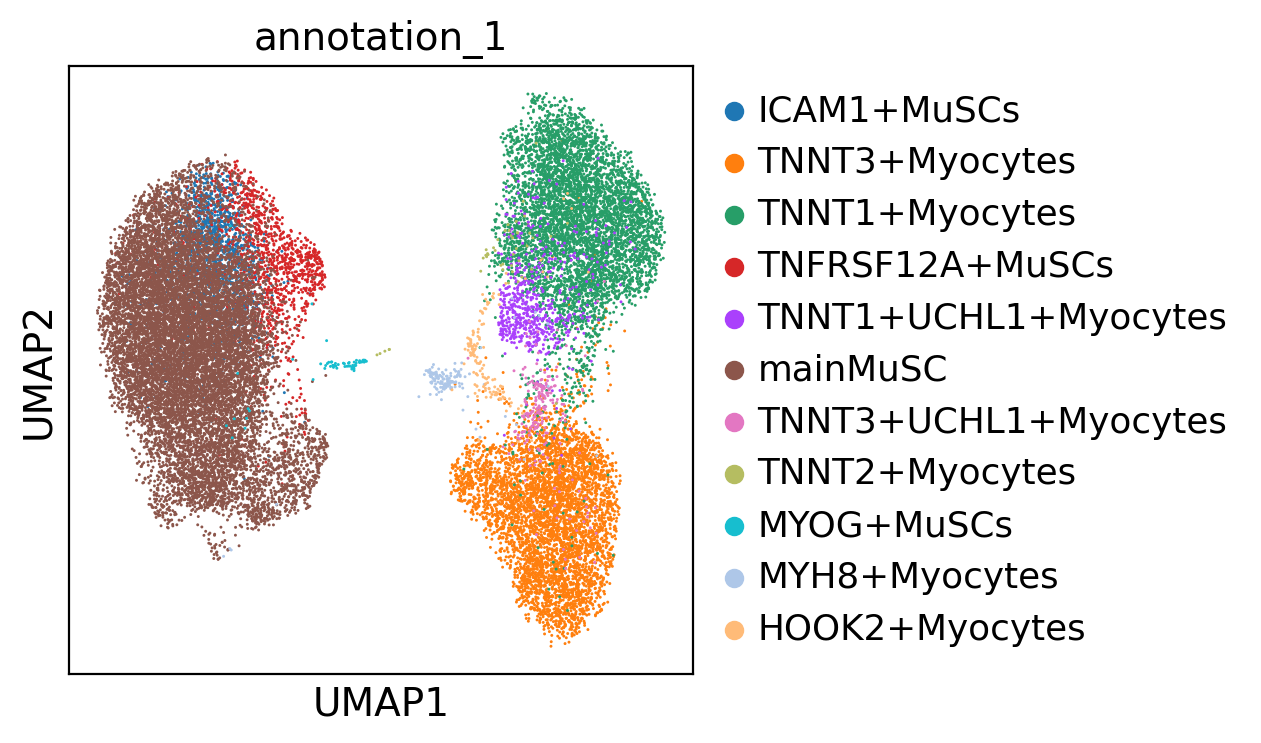

In [40]:
sc.pl.umap(adata, color='annotation_1', )

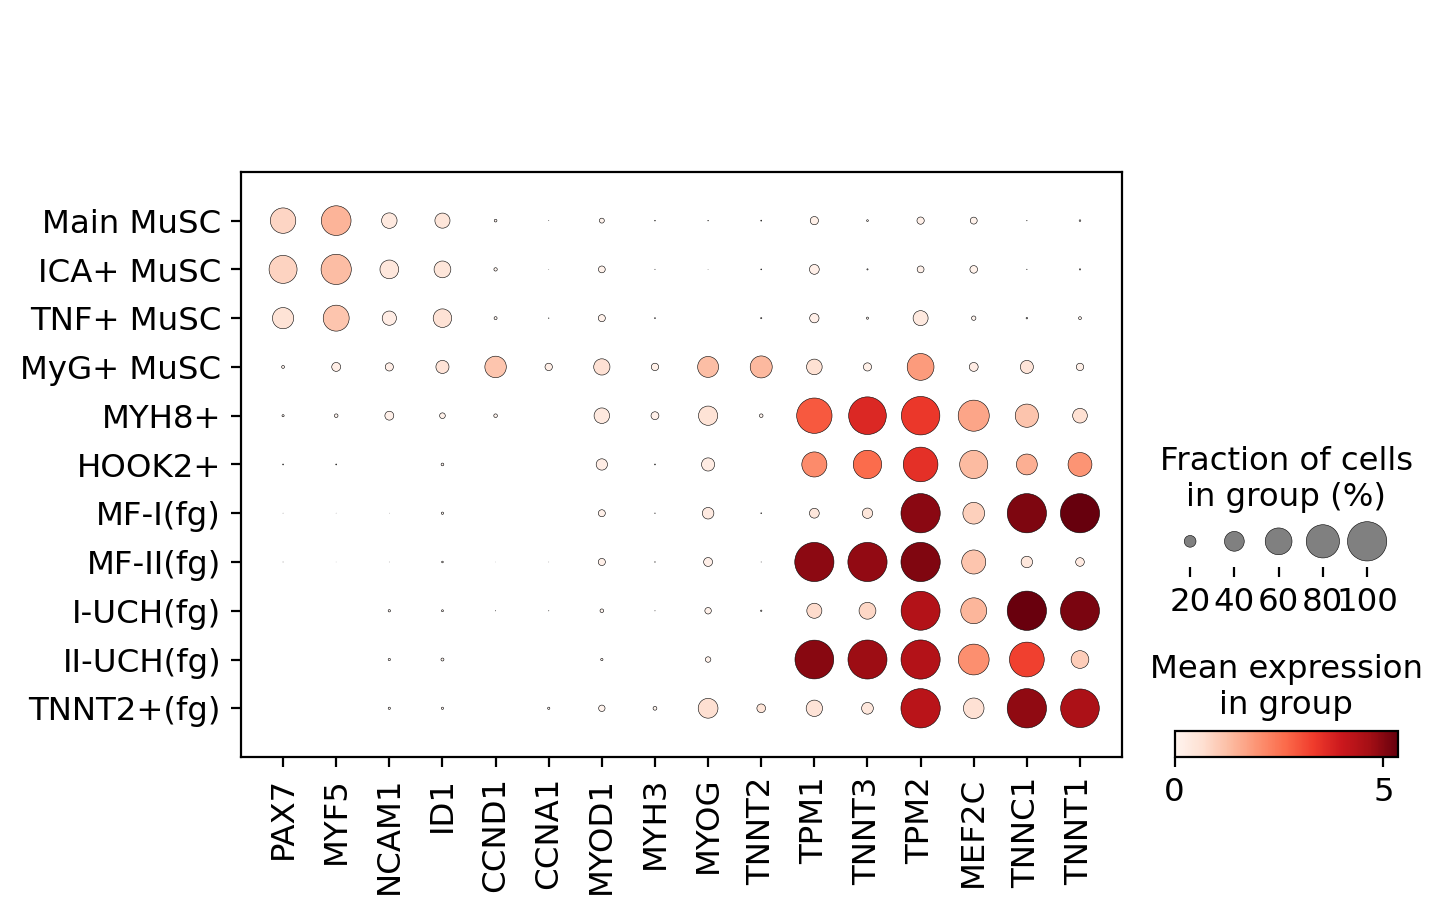

In [15]:
sc.pl.dotplot(adata,['PAX7','MYF5',"NCAM1","ID1","CCND1", "CCNA1",'MYOD1', "MYH3","MYOG",'TNNT2',"TPM1", 'TNNT3', "TPM2","MEF2C","TNNC1","TNNT1",],groupby='annotation_2',categories_order=['Main MuSC','ICA+ MuSC','TNF+ MuSC','MyG+ MuSC','MYH8+','HOOK2+','MF-I(fg)','MF-II(fg)','I-UCH(fg)','II-UCH(fg)','TNNT2+(fg)',],save='humsn_SKM_MuSC_Myocyte_scVI_v1.3_marker_v2.pdf')